In [31]:
import pandas as pd
import os
import sys

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)

from packages.utils import cloud_cnxn, seasons, season_conversion
c_con, c_eng = cloud_cnxn()
SEASON = seasons()[-1]
SCHEMA = season_conversion(SEASON)
market = 'totals'
print(SEASON, SCHEMA, market)

2025-26 202526 totals


In [32]:
details = pd.read_sql_query(f"""select * from "{SCHEMA}".odds_details limit 1""", con=c_eng)
details

,id,commence_time_utc,home_team,away_team
0,bbde7751a144b98ed150d7a5f7dc8f87,2025-10-21 23:35:00,Oklahoma City Thunder,Houston Rockets


In [33]:
id = details.loc[0, "id"]
odds = pd.read_sql_query(f"""select * from "{SCHEMA}".odds_{market} where id = '{id}'""", con=c_eng)
odds

,id,bookmaker,last_update_utc,query_time_est,name,price,point,prev_price,prev_point
0,bbde7751a144b98ed150d7a5f7dc8f87,betmgm,2025-10-17 02:00:21,2025-10-16 22:00:01,Over,1.95,227.5,NaN,NaN
1,bbde7751a144b98ed150d7a5f7dc8f87,betmgm,2025-10-17 14:00:04,2025-10-17 10:00:01,Over,1.87,226.5,1.95,227.5
2,bbde7751a144b98ed150d7a5f7dc8f87,betmgm,2025-10-18 15:59:52,2025-10-18 12:00:01,Over,1.91,226.5,1.87,226.5
3,bbde7751a144b98ed150d7a5f7dc8f87,betmgm,2025-10-20 16:00:32,2025-10-20 12:00:00,Over,1.87,226.5,1.91,226.5
4,bbde7751a144b98ed150d7a5f7dc8f87,betmgm,2025-10-20 16:58:18,2025-10-20 13:00:01,Over,1.91,227.5,1.87,226.5
...,...,...,...,...,...,...,...,...,...
418,bbde7751a144b98ed150d7a5f7dc8f87,williamhill_us,2025-10-21 21:58:06,2025-10-21 18:00:01,Under,1.91,227.5,1.95,227.5
419,bbde7751a144b98ed150d7a5f7dc8f87,williamhill_us,2025-10-21 23:00:06,2025-10-21 19:00:00,Under,1.91,227.0,1.91,227.5
420,bbde7751a144b98ed150d7a5f7dc8f87,williamhill_us,2025-10-21 23:59:47,2025-10-21 20:00:02,Under,1.80,235.5,1.91,227.0
421,bbde7751a144b98ed150d7a5f7dc8f87,williamhill_us,2025-10-22 00:59:57,2025-10-21 21:00:01,Under,1.91,223.5,1.80,235.5


In [34]:
##### The base dataset for odds analysis

sql = f"""
    select
        d.id
        ,d.home_team
        ,d.away_team
        ,m.bookmaker
        ,m.last_update_utc
        ,m.name
        ,m.price
        ,m.point    -- h2h will not have this column!
    from "{SCHEMA}".odds_details as d
    left join "{SCHEMA}".odds_{market} as m
        on d.id = m.id
    where d.id = '{id}'   
    """

event = pd.read_sql_query(sql, con=c_eng)
event

,id,home_team,away_team,bookmaker,last_update_utc,name,price,point
0,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,betmgm,2025-10-17 02:00:21,Over,1.95,227.5
1,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,betmgm,2025-10-17 14:00:04,Over,1.87,226.5
2,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,betmgm,2025-10-18 15:59:52,Over,1.91,226.5
3,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,betmgm,2025-10-20 16:00:32,Over,1.87,226.5
4,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,betmgm,2025-10-20 16:58:18,Over,1.91,227.5
...,...,...,...,...,...,...,...,...
418,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,williamhill_us,2025-10-21 21:58:06,Under,1.91,227.5
419,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,williamhill_us,2025-10-21 23:00:06,Under,1.91,227.0
420,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,williamhill_us,2025-10-21 23:59:47,Under,1.80,235.5
421,bbde7751a144b98ed150d7a5f7dc8f87,Oklahoma City Thunder,Houston Rockets,williamhill_us,2025-10-22 00:59:57,Under,1.91,223.5


Oklahoma City Thunder
williamhill_us


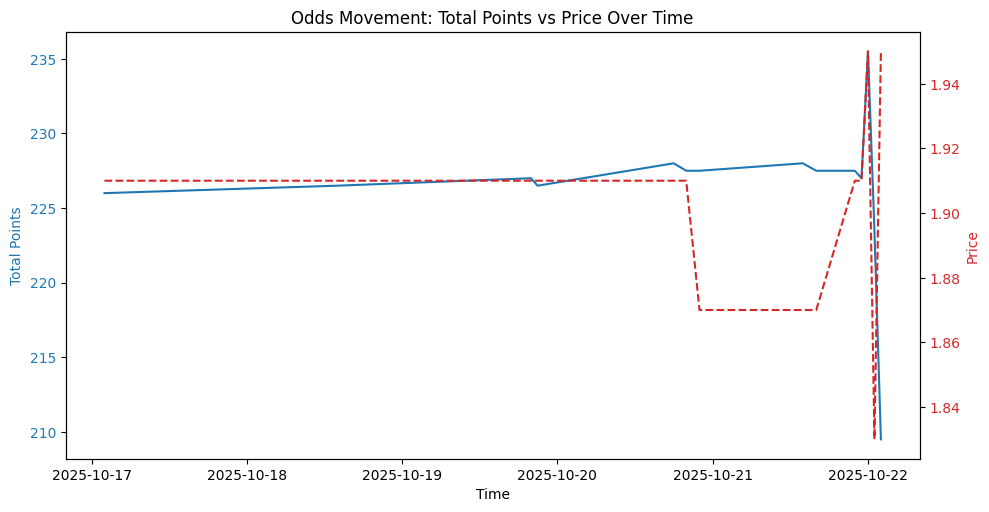

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

for team in event.home_team.unique()[-1:]:
    print(team)
    for bookmaker in event.bookmaker.unique()[-1:]:
        print(bookmaker)
        df = event[(event.bookmaker==bookmaker) & (event.home_team==team) & (event.name=="Over")]
        fig, ax1 = plt.subplots(figsize=(10,5))

        ax1.set_xlabel('Time')
        ax1.set_ylabel('Total Points', color='tab:blue')
        ax1.plot(df['last_update_utc'], df['point'], color='tab:blue', label='Total Points')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()  # second y-axis
        ax2.set_ylabel('Price', color='tab:red')
        ax2.plot(df['last_update_utc'], df['price'], color='tab:red', linestyle='--', label='Price')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        fig.tight_layout()
        plt.title("Odds Movement: Total Points vs Price Over Time")
        plt.show()


## Variables
#### Team
#### Name   (h2h:Team, spreads:Team, totals:Over/Under)
#### Point  (spreads:Points Difference, totals:Combined Points)
#### Price

,id,home_team,away_team,bookmaker,last_update_utc,name,price,point
